# Track on Radar data, Segment on satellite data


This notebooks shows:
- how to input NEXRAD radar data and GOES satellite data from Amazon cloud service and prepare it for use in tobac
- how to identify features on one data type (3D radar data) and to connect another data type (satellite data) to these features via segmentation


This is an idealized show case that ignores potential data mismatches, in our case the mismatch due to parallax effects.


## Library Imports

*Note: In addition to the normal *tobac* requirements, this tutorial also requires that Py-ART and s3fs are installed.*


In [1]:
# Import libraries:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import s3fs
import pyart
from pyproj import Proj, Geod

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm as cmaps
import cartopy.crs as ccrs

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Disable a few warnings:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)

In [3]:
# Import tobac itself:
import tobac
import tobac.utils

print("using tobac version", str(tobac.__version__))

using tobac version 1.5.5


## Data Input and Preparations

### Reading radar data and satellite data from Amazon S3

In [4]:
# Initialise s3 filesystem
fs = s3fs.S3FileSystem(anon=True)

In [5]:
# Find nexrad files on NOAA archive matching the following site code and date:
nexrad_site = "KGLD"
date = datetime(2021, 5, 26, 15, 56)

nexrad_files = [
    f for f in fs.find(
        f's3://noaa-nexrad-level2/{date.year:04d}/{date.month:02d}/{date.day:02d}/{nexrad_site}', 
        prefix=f'{nexrad_site}{date.strftime("%Y%m%d_%H%M")}'
    ) if f.endswith("_V06")
]

assert len(nexrad_files), f'No files found matching site: {nexrad_site}, date: {date}'

In [6]:
# read in radar data
radar = pyart.io.read_nexrad_archive(
    f's3://{nexrad_files[0]}'
)

In [7]:
# Find GOES-16 mesoscan region matching radar timestamp:
goes_files = fs.find(
    f's3://noaa-goes16/ABI-L2-MCMIPM/{date.year:04d}/{date.strftime("%j")}/{date.hour:02d}', 
    prefix=f'OR_ABI-L2-MCMIPM2-M6_G16_s{date.strftime("%Y%j%H%M")}'
)

assert len(goes_files), f'No GOES file found matching date: {date}'

In [8]:
# read in satellite data
goes_data = xr.open_dataset(fs.open(goes_files[0]), engine="h5netcdf")

In [9]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

### Preparing GOES satellite data

In the next steps, we
- calculate longitude and latitude values using geostationary satellite projection
- construct a GOES dataset with lon/lat as coordinates
- rename the "t" coordinate to "time" to conform with tobac standards

In [10]:
"""
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
"""

def lat_lon_reproj(goes_dataset):
    # Create projection object using GOES-16 projection info:
    g16_proj = Proj(
        proj="geos",
        h=goes_dataset.goes_imager_projection.perspective_point_height,
        lon_0=goes_dataset.goes_imager_projection.longitude_of_projection_origin,
        lat_0=goes_dataset.goes_imager_projection.latitude_of_projection_origin,
        sweep=goes_dataset.goes_imager_projection.sweep_angle_axis,
    )

    # Map x/y coords in goes_dataset to lat/lon:
    lon, lat = g16_proj(
        *np.meshgrid(
            goes_dataset.x.values * goes_dataset.goes_imager_projection.perspective_point_height, 
            goes_dataset.y.values * goes_dataset.goes_imager_projection.perspective_point_height, 
        ), 
        inverse=True, 
    )

    # Return goes_dataset with lat and lon added to coordinates:
    return goes_dataset.assign_coords(
        lon=(("y", "x"), lon), 
        lat=(("y", "x"), lat), 
    )

In [11]:
# Extract channel 13 brightness temperature field:
BT_C13 = lat_lon_reproj(goes_data).CMI_C13.expand_dims("t")

# We need to rename the "t" coord and dimension to "time" for tobac:
BT_C13 = BT_C13.rename(t="time")

In [12]:
BT_C13

<xarray.DataArray 'CMI_C13' (time: 1, y: 500, x: 500)> Size: 1MB
array([[[270.29276, 270.04694, 269.12515, ..., 286.14774, 285.47174,
         285.10303],
        [270.1084 , 269.67822, 266.35974, ..., 288.05276, 287.3768 ,
         285.16446],
        [264.51614, 262.91837, 256.2814 , ..., 288.97458, 289.4662 ,
         286.7008 ],
        ...,
        [300.1591 , 299.11438, 297.02496, ..., 291.67853, 293.82938,
         294.38248],
        [298.62274, 299.42163, 297.8853 , ..., 292.84613, 294.56683,
         294.997  ],
        [297.82385, 297.6395 , 297.70096, ..., 293.3992 , 294.01373,
         293.33777]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2021-05-26T15:56:56.499348992
  * y        (y) float32 2kB 0.1181 0.1181 0.118 ... 0.0903 0.09024 0.09019
  * x        (x) float32 2kB -0.06493 -0.06488 -0.06482 ... -0.03704 -0.03699
    y_image  float32 4B ...
    x_image  float32 4B ...
    lon      (y, x) float64 2MB -109.7 -109.7 -109.6 ... -89.68 -89.66 -89.64
    lat      (y, x) float64 2MB 46.08 46.08 46.08 46.08 ... 31.76 31.76 31.76
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C13

**Visualisation**

We can visualise the channel 13 BT field using an enhanced colourmap which uses colours for the coldest temperatures:

In [13]:
def enhanced_colormap(vmin=200.0, vmed=240.0, vmax=300.0):
    '''
    Creates enhanced colormap typical of IR BTs.
    '''
    nfull = 256

    ngray = int(nfull * (vmax - vmed) / (vmax - vmin))
    ncol = nfull - ngray

    colors1 = plt.cm.gray_r(np.linspace(0.0, 1.0, ngray))
    colors2 = plt.cm.Spectral(np.linspace(0., 0.95, ncol))

    # combine them and build a new colormap
    colors = np.vstack((colors2, colors1))
    mymap = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        "enhanced_colormap", colors
    )

    return mymap

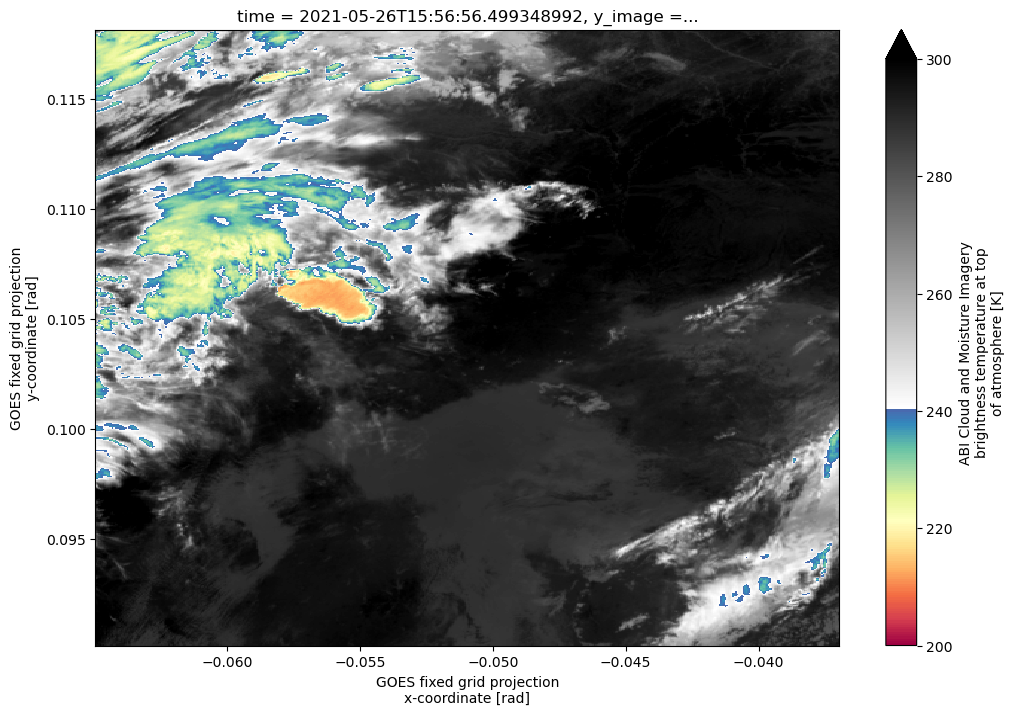

In [14]:
BT_C13.plot(vmin=200, vmax=300.0, cmap=enhanced_colormap(), figsize=(12, 8))

### Preparing Radar Data

In the next steps, we
- map radar data onto a regular grid
- construct a 3D radar dataset and add longitude, latitude and altitude as coordinates
- finally, convert the dataset into an Iris Cube (which is taken as tobac input)

In [15]:
# First, we need to grid the input radar data.
radar_grid_pyart = pyart.map.grid_from_radars(
    radar,
    grid_shape=(41, 401, 401),
    grid_limits=((0.0, 2e4), (-2e5, 2e5), (-2e5, 2e5),),
)

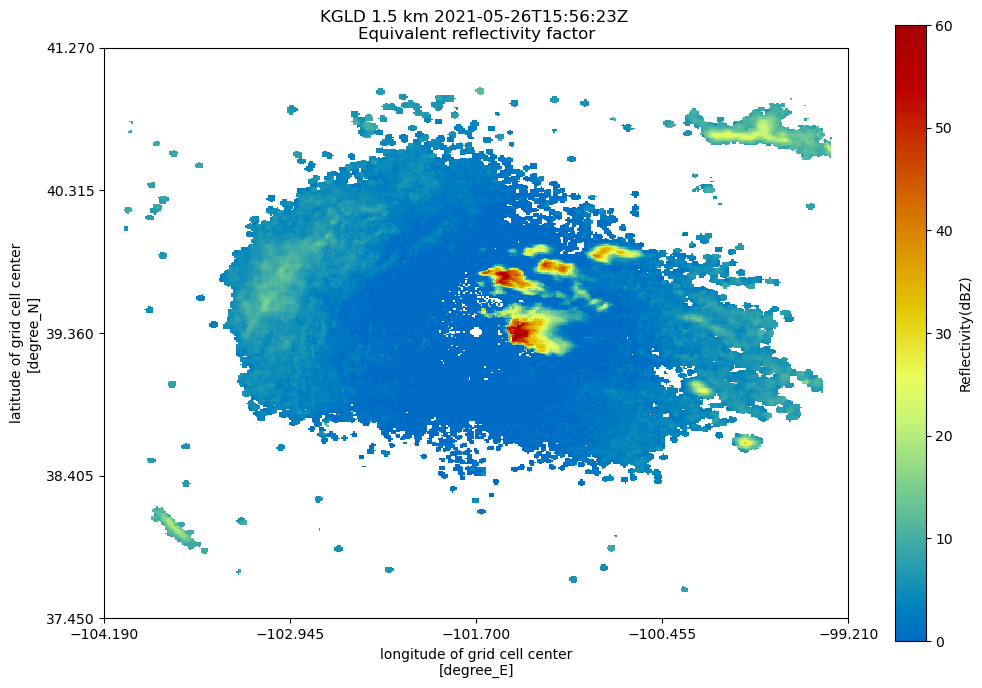

In [16]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[12, 8])
pyart.graph.GridMapDisplay(radar_grid_pyart).plot_grid("reflectivity", level=3, vmin=0, vmax=60, fig=fig)

In [17]:
# Convert radar reflectivity field to a DataArray
Z = radar_grid_pyart.to_xarray().reflectivity.drop_vars(['origin_altitude', 'origin_longitude', 'origin_latitude'], errors='ignore')

In [18]:
Z

<xarray.DataArray 'reflectivity' (time: 1, z: 41, y: 401, x: 401)> Size: 26MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time                        (time) object 8B 2021-05-26 15:56:23.106000
  * z                           (z) float64 328B 0.0 500.0 ... 1.95e+04 2e+04
    lat                         (y, x) float64 1MB 37.55 37.55 ... 41.14 41.14
    lon                         (y, x) float64 1MB -104.0 -104.0 ... -99.31
  * y                           (y) float64 3kB -2e+05 -1.99e+05 ... 2e+05
  * x                           (x) float64 3kB -2e+05 -1.99e+05 ... 2e+05
    ProjectionCoordinateSystem  int32 4B 1
    projection                  int32 4B 1
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    valid_max:      94.5
    valid_min:      -32.0
    coordinates:    elevation azimuth range
    _FillValue:     -9999.0

### Combined Plot

(37.54600438517133, 41.16558741816462)

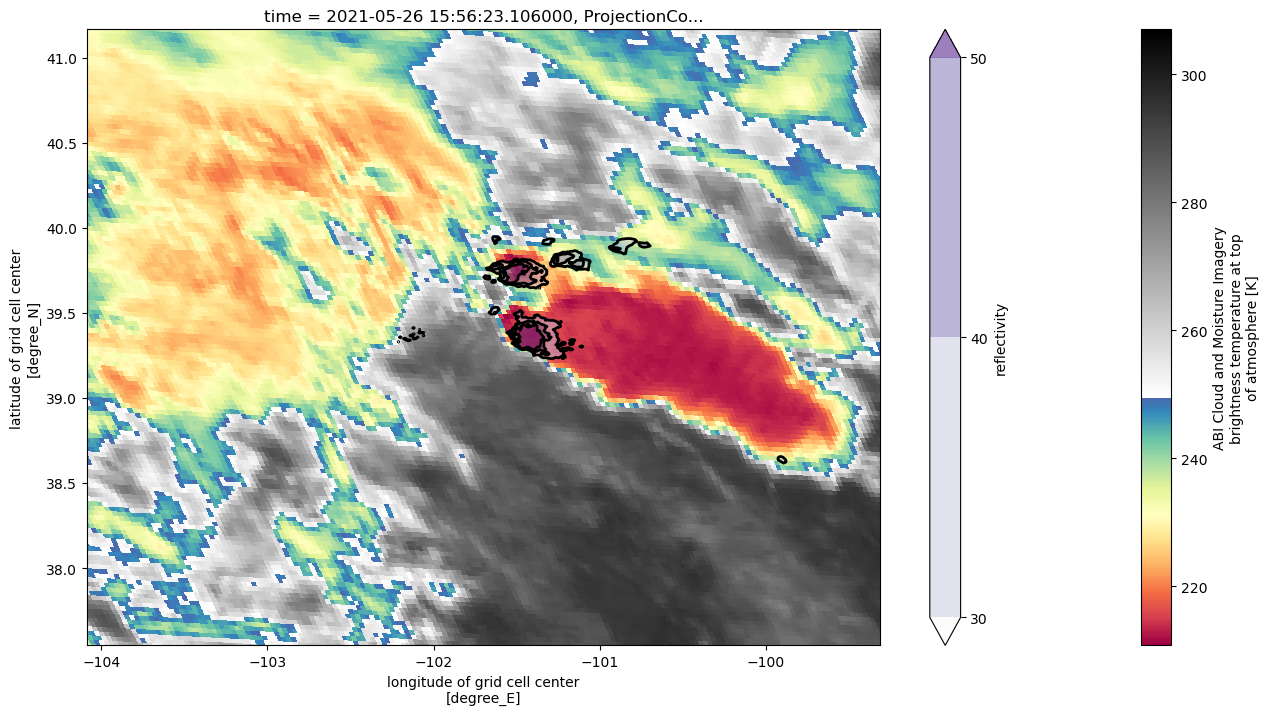

In [19]:
BT_C13.plot(
    x="lon", y="lat", cmap=enhanced_colormap(), figsize=(16, 8)
)

Zmax = Z.max("z").isel(time=0)

Zmax.where(Zmax > 29.9).plot.contourf(
    x="lon",
    y="lat",
    cmap=plt.cm.Purples,
    levels=[30, 40, 50],
    alpha=0.5,
)

Zmax.plot.contour(
    x="lon", y="lat", colors="k", levels=[30, 40, 50], linewidths=2
)

plt.xlim(Z.lon.min(), Z.lon.max())
plt.ylim(Z.lat.min(), Z.lat.max())

## Tobac Cloud Tracking

### Feature detection

We use multiple thresholds to detect features in the radar data.

In [20]:
feature_detection_params = dict()
feature_detection_params["threshold"] = [30, 40, 50]
feature_detection_params["target"] = "maximum"
feature_detection_params["position_threshold"] = "weighted_diff"
feature_detection_params["n_erosion_threshold"] = 2
feature_detection_params["sigma_threshold"] = 1
feature_detection_params["n_min_threshold"] = 4

In [21]:
# Perform feature detection:
print('starting feature detection')
radar_features = tobac.feature_detection.feature_detection_multithreshold(
    Z, 0, **feature_detection_params
)
radar_features.to_hdf(savedir / 'Features.h5', 'table')
print('feature detection performed and saved')

starting feature detection
feature detection performed and saved


In [22]:
radar_features.head()

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,z,lat,lon,y,x,ProjectionCoordinateSystem,projection
0,0,4,1.068872,259.573203,271.473081,83,30,1,2021-05-26 15:56:23.106000,2021-05-26 15:56:23,534.436123,39.899706,-100.862428,59573.202737,71473.081165,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...
1,0,8,0.763795,247.381838,248.761000,9,40,2,2021-05-26 15:56:23.106000,2021-05-26 15:56:23,381.897639,39.791669,-101.129573,47381.838290,48761.000115,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...
2,0,9,0.182909,249.811722,239.022835,14,40,3,2021-05-26 15:56:23.106000,2021-05-26 15:56:23,91.454702,39.814021,-101.243403,49811.722498,39022.834724,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...
3,0,11,0.847673,200.437205,224.096898,54,50,4,2021-05-26 15:56:23.106000,2021-05-26 15:56:23,423.836594,39.370539,-101.419953,437.205190,24096.897746,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...
4,0,12,1.489936,241.403604,215.515658,54,50,5,2021-05-26 15:56:23.106000,2021-05-26 15:56:23,744.967852,39.739154,-101.518821,41403.604269,15515.658193,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...


Text(0.5, 1.0, 'KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56')

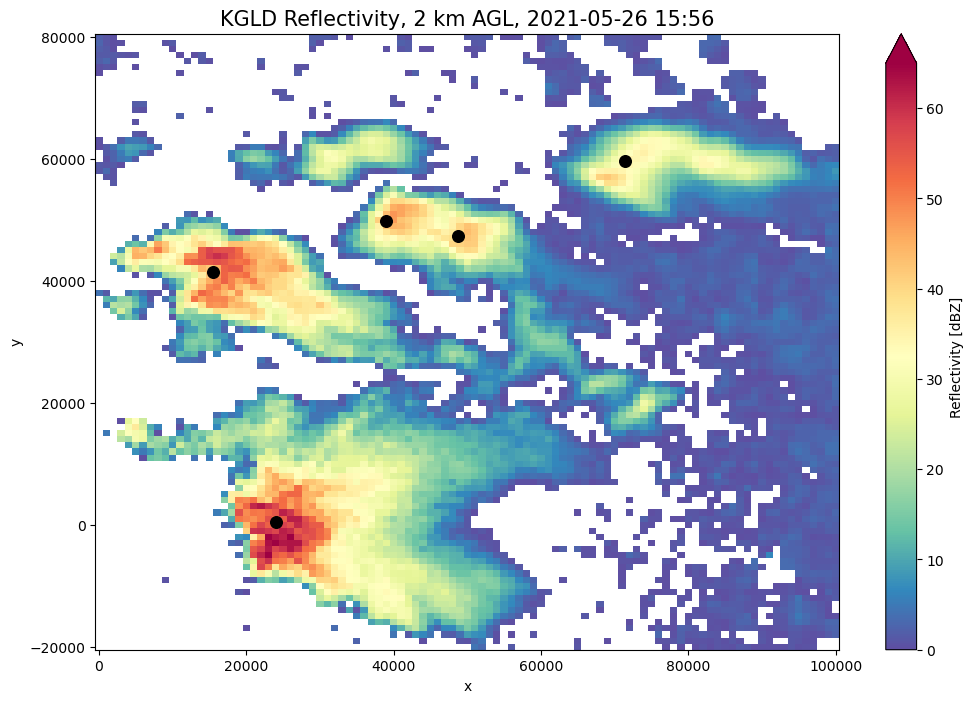

In [23]:
Z[0, 4,].where(Z[0, 4,] > 0).loc[-2e4:8e4, 0:1e5].plot(vmin=0, vmax=65, cmap="Spectral_r", figsize=(12,8))

plt.scatter(
    radar_features["x"],
    radar_features["y"],
    70,
    color="k",
)
plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)


### Transform feature locations to GOES-16 grid

To convert the previously detected features between the radar field of view and that of the satellite, we use the `tobac.utils.transform_feature_points` function. Note that because the radar detection was performed in 3D, we need to drop the `vdim` column to transform the data to the 2D satellite field of view

In [24]:
# maximum space away in m,  maximum time away as Python Datetime object
goes_adj_features = tobac.utils.transform_feature_points(
    radar_features.drop(columns="vdim"),
    BT_C13,
    max_time_away=timedelta(minutes=1),
    max_space_away=20 * 1000,
)

In [25]:
goes_adj_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,z,lat,lon,y,x,ProjectionCoordinateSystem,projection,y_image,x_image
index,,,,,,,,,,,,,,,,,,
0,0.0,4.0,192.0,156.0,83.0,30.0,1,2021-05-26 15:56:56,2021-05-26 15:56:23,534.436123,39.899706,-100.862428,59573.202737,71473.081165,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,0.10416,-0.05096
1,0.0,8.0,197.0,144.0,9.0,40.0,2,2021-05-26 15:56:56,2021-05-26 15:56:23,381.897639,39.791669,-101.129573,47381.838290,48761.000115,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,0.10416,-0.05096
2,0.0,9.0,196.0,141.0,14.0,40.0,3,2021-05-26 15:56:56,2021-05-26 15:56:23,91.454702,39.814021,-101.243403,49811.722498,39022.834724,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,0.10416,-0.05096
3,0.0,11.0,213.0,127.0,54.0,50.0,4,2021-05-26 15:56:56,2021-05-26 15:56:23,423.836594,39.370539,-101.419953,437.205190,24096.897746,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,0.10416,-0.05096
4,0.0,12.0,199.0,130.0,54.0,50.0,5,2021-05-26 15:56:56,2021-05-26 15:56:23,744.967852,39.739154,-101.518821,41403.604269,15515.658193,<xarray.DataArray 'ProjectionCoordinateSystem'...,<xarray.DataArray 'projection' ()> Size: 4B\na...,0.10416,-0.05096


**Segmentation:**  

In [26]:
parameters_segmentation = dict()
parameters_segmentation["method"] = "watershed"
parameters_segmentation["threshold"] = 240
parameters_segmentation["target"] = "minimum"
parameters_segmentation["seed_3D_flag"] = "box"
parameters_segmentation["seed_3D_size"] = 5

In [27]:
# Perform segmentation and save results:
print('Starting segmentation.')
segmentation_mask, segmentation_features = tobac.segmentation.segmentation(
    goes_adj_features, BT_C13, dxy=2000, **parameters_segmentation
)
print('segmentation performed, start saving results to files')
segmentation_mask.to_netcdf(savedir / 'Mask_Segmentation_sat.nc', encoding={"segmentation_mask":{"zlib":True, "complevel":4}})
segmentation_features.to_hdf(savedir / 'Features_sat.h5', 'table')
print('segmentation performed and saved')

Starting segmentation.
segmentation performed, start saving results to files
segmentation performed and saved


In [28]:
segmentation_mask.coords

Coordinates:
  * time     (time) datetime64[ns] 8B 2021-05-26T15:56:56.499348992
  * y        (y) float32 2kB 0.1181 0.1181 0.118 ... 0.0903 0.09024 0.09019
  * x        (x) float32 2kB -0.06493 -0.06488 -0.06482 ... -0.03704 -0.03699
    y_image  float32 4B ...
    x_image  float32 4B ...
    lon      (y, x) float64 2MB -109.7 -109.7 -109.6 ... -89.68 -89.66 -89.64
    lat      (y, x) float64 2MB 46.08 46.08 46.08 46.08 ... 31.76 31.76 31.76

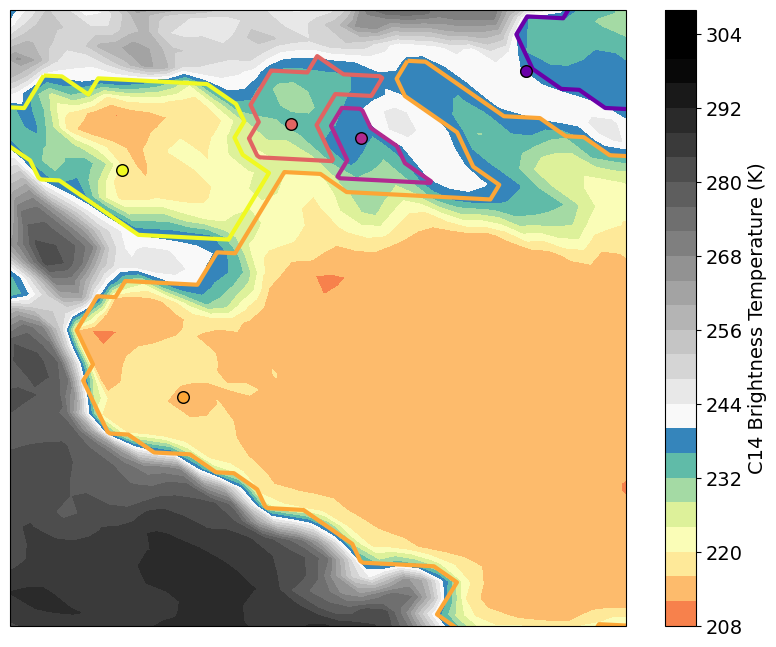

In [29]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

contoured = ax.contourf(
    BT_C13["lon"],
    BT_C13["lat"],
    BT_C13[0],
    transform=ccrs.PlateCarree(),
    cmap=enhanced_colormap(), vmin = 200, vmax = 300, levels = 31
)
plt.xlim(-101.7, -100.7)
plt.ylim(39.0, 40)
unique_seg = np.unique(segmentation_mask)
color_map = cmaps.plasma(np.linspace(0, 1, len(unique_seg)))

# we have one feature without a segmented area
curr_feat = goes_adj_features[goes_adj_features["feature"] == 1]
plt.scatter(
    curr_feat["lon"],
    curr_feat["lat"],
    70,
    transform=ccrs.PlateCarree(),
    color="grey",
)


for seg_num, color in zip(unique_seg, color_map):
    if seg_num == 0 or seg_num == -1:
        continue
    curr_seg = (segmentation_mask == seg_num).astype(int)
    ax.contour(
        segmentation_mask["lon"],
        segmentation_mask["lat"],
        curr_seg.isel(time=0),
        colors=[
            color,
        ],
        levels=[
            0.9,1
        ],
        linewidths=3,
    )
    curr_feat = goes_adj_features[goes_adj_features["feature"] == seg_num]
    plt.scatter(
        curr_feat["lon"],
        curr_feat["lat"],
        70,
        transform=ccrs.PlateCarree(),
        color=color,
        edgecolors = 'black',
        zorder = 10
    )

cb = plt.colorbar(contoured)
cb.set_label("C14 Brightness Temperature (K)", size=14)
cb.ax.tick_params(labelsize=14)
# plt.savefig("./radar_example_2/satellite_wseg.png", facecolor='w', bbox_inches='tight')

*result*:
- convective anvils could be connected to two respective radar cells
- ignoring parallax shifts can cause assignment problems for smaller anvils (see purple radar cell)